<a href="https://colab.research.google.com/github/adityap86/similar_images/blob/master/similarity_find.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading the data

In [1]:
!wget "http://aws-proserve-data-science.s3.amazonaws.com/geological_similarity.zip"


--2020-03-22 08:02:09--  http://aws-proserve-data-science.s3.amazonaws.com/geological_similarity.zip
Resolving aws-proserve-data-science.s3.amazonaws.com (aws-proserve-data-science.s3.amazonaws.com)... 52.218.228.35
Connecting to aws-proserve-data-science.s3.amazonaws.com (aws-proserve-data-science.s3.amazonaws.com)|52.218.228.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35312590 (34M) [application/zip]
Saving to: ‘geological_similarity.zip’

geological_similari 100%[===================>]  33.68M  14.0MB/s    in 2.4s    

2020-03-22 08:02:11 (14.0 MB/s) - ‘geological_similarity.zip’ saved [35312590/35312590]



## Unzipping the data

In [0]:
!unzip geological_similarity.zip

In [0]:
!ls -l

In [0]:
import glob
file_paths = glob.glob('geological_similarity/*/*.jpg',recursive=True)

In [0]:
file_paths

In [50]:
print("Number of images",len(file_paths))

Number of images 29998


In [0]:
import pandas as pd
file_paths_df = pd.DataFrame(file_paths,columns=['paths'])

In [0]:
file_paths_df['broad_class_labels'] = file_paths_df['paths'].apply(lambda x: x.split("/")[1])

In [33]:
print("Division per broad class labels",file_paths_df.groupby(by='broad_class_labels').count())

Division per broad class labels                     paths
broad_class_labels       
andesite             5000
gneiss               5000
marble               4998
quartzite            5000
rhyolite             5000
schist               5000


### Picking pre-trained VGG16 Model and selecting the last layer before softmax, Max Pooled

In [0]:
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
def load_model():
  """
  :return: model to extract features for each image
  """
  model = VGG16(weights='imagenet', include_top=False,pooling='max')
  return model

In [0]:
from keras.preprocessing import image
import numpy as np
from scipy.spatial.distance import pdist,squareform
import random 
def preprocess_load(img_path,model):
  """
  :param img_path: Input image path 
  :param model: Model to get image features
  :return: Flatten features for the given image
  """
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  features = features.flatten()
  return features

def get_features(pd_df):
  """
  :param pd_df: Input dataframe with paths
  :return: Input dataframe with features
  """
  model = load_model()
  pd_df['features'] = pd_df['paths'].apply(lambda x: preprocess_load(x,model))
  return pd_df

def calculate_similarity(pd_df,dist_type):
  """
  :param pd_df: Input dataframe with paths
  :param dist_type: Distance metric
  :return: Similarity Distance Dataframe (Matrix)
  """

  print("size of features",(pd_df['features'].iloc[0]).shape)
  features_np = np.stack(pd_df['features'].values, axis=0)
  features_np_dist = pdist(features_np, metric=dist_type)
  dist_matrix = squareform(features_np_dist)
  print("shape of distance matrix", dist_matrix.shape)
  similarity_df = pd.DataFrame(dist_matrix,columns = pd_df.paths,index=pd_df.paths)
  return similarity_df


In [0]:
def get_similar(idx,df,k,p_flag):
  """
  :param idx: image path for given image
  :param df: similarity distance matrix
  :param k: top K of given image
  :param p_flag: Boolean type (To enable prints)
  :return: K top image paths
  """
  #Check whether image is in the dataframe or not
  ind = similar_mat.index
  if inp_img in ind:
    cosine_data = df.loc[idx]
    top_5 = cosine_data.sort_values()[1:k]
    paths = top_5.index.tolist()
    if p_flag:
      print("Found Images",paths)
    return paths
  else:
    if p_flag:
      print("Input image doesnt belong in the repository")
    return False


In [0]:
import matplotlib.pyplot as plt
from PIL import Image
def show_imgs(idx,paths):
  """
  Plots all image, input and output image
  :param idx: image path for given image
  :param paths: Similar images
  :return: None
  """
  print("Input image")
  plt.imshow(image.load_img(idx))
  plt.show()
  print("Output image")
  for path in paths:
    plt.imshow(image.load_img(path))
    plt.show()

def calculate_avg_mse(img,contentders):
  """
  Calculate Average Mean Square Error
  :param idx: image path for given image
  :param paths: Similar images
  :return: None
  """
  img_np = np.array((image.load_img(img)))/255
  total_err = []
  for img_c in contentders:
    img_c_np = np.array((image.load_img(img_c)))/255
    err = np.sum((img_np.astype("float") - img_c_np.astype("float")) ** 2)
    err /= float(img_np.shape[0] * img_np.shape[1])
    total_err.append(err)

  avg_err = (np.mean(total_err))
  return avg_err


### Main Function, To get top K images

In [77]:

if __name__ == '__main__':
  # Calculate features for each given image
  file_paths_df = get_features(file_paths_df)
  # Calculate distnace matrix (Square matrix)
  similar_mat = calculate_similarity(file_paths_df,'cityblock')

  cal_metric = True
  arr_k=[5,15]
  t_mse = 0
  c = 0
  print_flag = False
  if cal_metric:
    k = arr_k[0]
    for ind,g_img in file_paths_df.iterrows():
      given_img = g_img.paths
      s_img = get_similar(given_img,similar_mat,k,print_flag)
      a_mse = calculate_avg_mse(given_img,s_img)
      c += 1
      t_mse += a_mse
    avg_mse = t_mse/c
    print("Average MSE for given Distance",avg_mse)

  # Take random image
  r_number = random.randrange(len(file_paths_df))
  inp_img = file_paths_df.paths.iloc[r_number]
  print("Random Number",r_number)
  print("Random Input image",inp_img)
  # Select top K, example 5,15
  for k in arr_k:
    print("k",k)
    out_img = get_similar(inp_img,similar_mat,k,print_flag)
    if out_img:
      print("Average MSE for the given image and similar images is",calculate_avg_mse(inp_img,out_img))
      print_flag:
      show_imgs(inp_img,out_img)
  
  

size of features (512,)
shape of distance matrix (29998, 29998)
Average MSE for given Distance 0.05329145706833711
k 5
Average MSE for the given image and similar images is 0.24512965970702008
k 15
Average MSE for the given image and similar images is 0.29780538265726453


### Printing input image and similar images for top 5 similar image

In [0]:
out_img = get_similar(inp_img,similar_mat,5,print_flag)

Input image


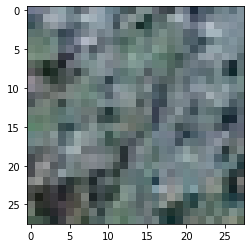

Output image


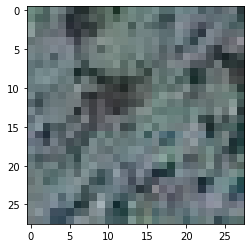

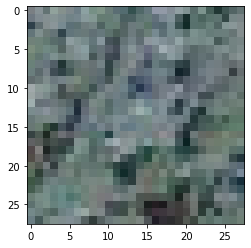

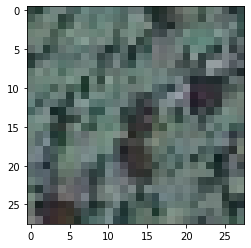

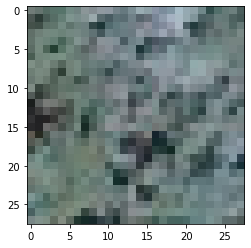

In [86]:
show_imgs(inp_img,out_img)